In [2]:
# ==========================
# 1. Imports
# ==========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import os

In [3]:
# ==========================
# 2. Device
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# ==========================
# 3. Paths
# ==========================
train_dir = "/kaggle/input/plants-dataset/CropsData/train"
test_dir  = "/kaggle/input/plants-dataset/CropsData/test"

In [5]:
# ==========================
# 4. Transforms
# ==========================
transform = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [6]:
# ==========================
# 5. Datasets & Loaders
# ==========================
train_dataset = datasets.ImageFolder(train_dir, transform=transform["train"])
test_dataset  = datasets.ImageFolder(test_dir, transform=transform["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes:", num_classes)

# ==========================
# 6. Model: MobileNetV2
# ==========================
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)




Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Classes: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']
Number of classes: 41


100%|██████████| 13.6M/13.6M [00:00<00:00, 82.6MB/s]


In [7]:
# ==========================
# 7. Loss & Optimizer
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [12]:
from tqdm import tqdm

# ==========================
# 8. Training
# ==========================
EPOCHS = 5
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Wrap your dataloader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]", leave=True)

    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        # Update tqdm progress bar with loss and accuracy
        pbar.set_postfix({
            "Loss": f"{running_loss/len(train_loader):.4f}",
            "Acc": f"{100*correct/total:.2f}%"
        })

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {acc:.2f}%")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_mobilenetv2.pth")


Epoch [1/5]: 100%|██████████| 481/481 [04:07<00:00,  1.94it/s, Loss=0.6734, Acc=79.50%]


Epoch [1/5] | Loss: 0.6734 | Accuracy: 79.50%


Epoch [2/5]: 100%|██████████| 481/481 [04:01<00:00,  1.99it/s, Loss=0.6242, Acc=81.09%]


Epoch [2/5] | Loss: 0.6242 | Accuracy: 81.09%


Epoch [3/5]: 100%|██████████| 481/481 [04:01<00:00,  1.99it/s, Loss=0.6017, Acc=81.71%]


Epoch [3/5] | Loss: 0.6017 | Accuracy: 81.71%


Epoch [4/5]: 100%|██████████| 481/481 [04:02<00:00,  1.98it/s, Loss=0.5711, Acc=82.44%]


Epoch [4/5] | Loss: 0.5711 | Accuracy: 82.44%


Epoch [5/5]: 100%|██████████| 481/481 [04:00<00:00,  2.00it/s, Loss=0.5478, Acc=82.96%]

Epoch [5/5] | Loss: 0.5478 | Accuracy: 82.96%


In [14]:
# ==========================
# 9. Evaluation
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

model.load_state_dict(torch.load("best_mobilenetv2.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ==========================
# Metrics
# ==========================
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


Accuracy : 0.8591
Precision: 0.8683
Recall   : 0.8591
F1-score : 0.8584

Classification Report:
                              precision    recall  f1-score   support

American Bollworm on Cotton       0.69      0.62      0.66       125
      Anthracnose on Cotton       0.94      0.90      0.92       125
                  Army worm       0.99      0.81      0.89       125
   Becterial Blight in Rice       0.98      0.65      0.78       125
                  Brownspot       0.88      0.86      0.87       125
                Common_Rust       0.98      0.95      0.96       125
               Cotton Aphid       0.86      0.96      0.91       125
                  Flag Smut       0.94      0.82      0.88       125
             Gray_Leaf_Spot       0.98      0.95      0.97       125
              Healthy Maize       1.00      0.98      0.99       125
              Healthy Wheat       0.69      0.87      0.77       125
             Healthy cotton       0.98      0.98      0.98       125
     

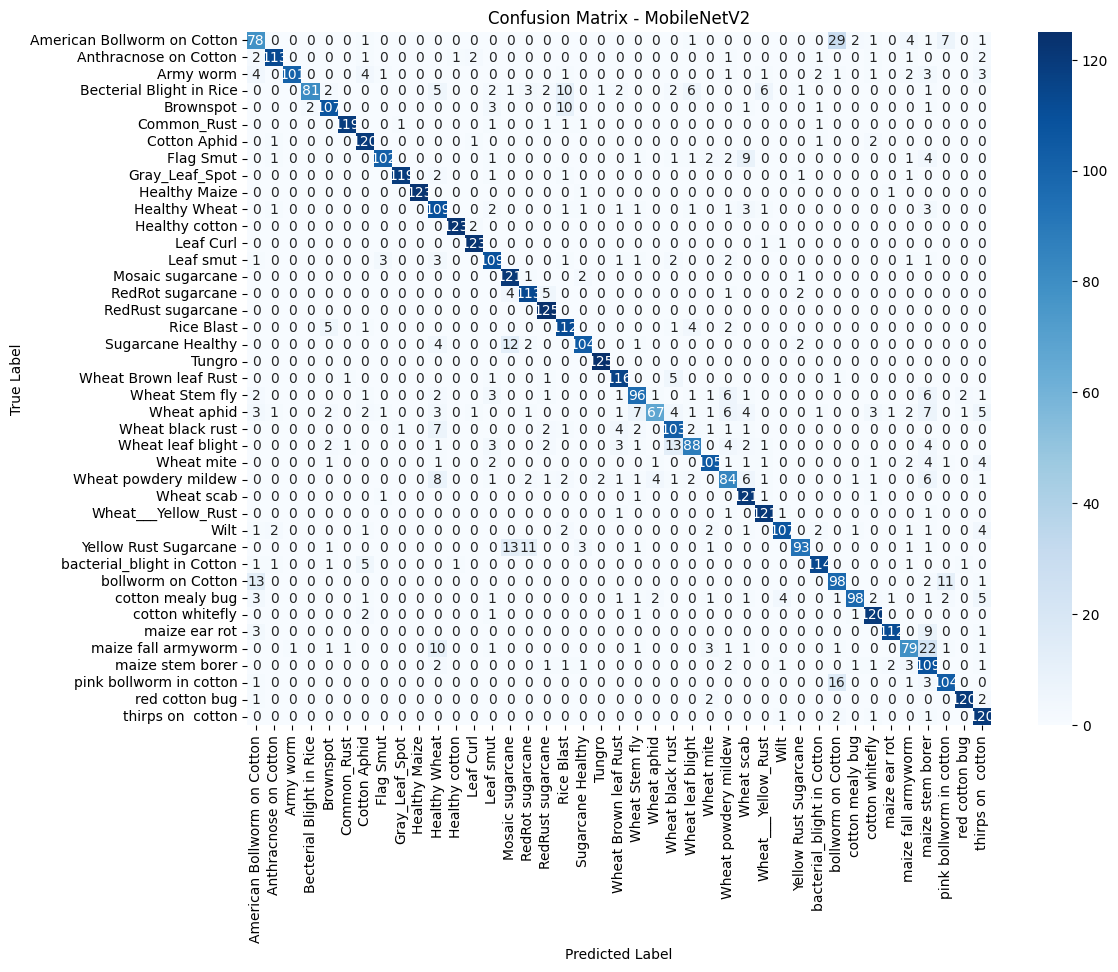

In [16]:
# ==========================
# Confusion Matrix
# ==========================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()